In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import pickle

from collections import Counter

import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

import string

from sklearn import model_selection, linear_model, naive_bayes, metrics, svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier

from scipy.sparse import hstack, vstack

### Open data
- train: Training data with labels
- test: Test data without labels
- rating: Concreteness ratings for 40,000 English lemma words
- aoa: Age of Acquisition estimates for about 51,000 English words
- dale: Dale Chall 3000 words, which are considered basic English words

In [7]:
train = pd.read_csv('data/WikiLarge_Train.csv')
test = pd.read_csv('data/WikiLarge_Test.csv')
rating = pd.read_csv('data/Concreteness_ratings_Brysbaert_et_al_BRM.txt', sep = '\t')
aoa = pd.read_csv('data/AoA_51715_words.csv', encoding='latin1')

In [8]:
with open('data/dale_chall.txt') as f:
    dale = set([l.strip() for l in list(f)])

### Split train data into train, dev, test 

In [9]:
def train_dev_test(df):
    train_df, dev_df, test_df =\
    np.split(train.sample(frac=1, random_state=695), [int(.7*len(train)), int(.9*len(train))])
    return train_df, dev_df, test_df

In [10]:
train_df, dev_df, test_df = train_dev_test(train)

In [11]:
train_df.reset_index(drop = True, inplace = True)
dev_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

### Prepare data and get features for prediction models

In [12]:
#nltk.download('stopwords')
stop = set(stopwords.words('english') + list(string.punctuation))

In [15]:
def word_count_tokenize(df):
    #word tokenize
    df['words'] = df['original_text'].str.split()
    
    #word count
    df['word_count'] = df['words'].str.len()
    
    #word punct tokenize
    df['word_punct'] = df['original_text'].apply(WordPunctTokenizer().tokenize)
    
    #sent tokenize
    df['sent_tokens'] = df['original_text'].apply(sent_tokenize)
    
    #word punct stopword removal
    return df

def get_clean_words(df):
    df['clean_word_punct'] = df['word_punct'].copy()
    df['clean_words'] = df['words'].copy()
    for i in range(len(df)):
        df.at[i,'clean_word_punct'] = [word for word in df.loc[i,'clean_word_punct'] if word not in stop]
        df.at[i,'clean_words'] = [word for word in df.loc[i,'clean_words'] if word not in stop]
    return df

In [16]:
conc = list(rating[rating['Conc.M']<2.0]['Word'])
percent_known = list(rating[rating['Percent_known']<0.92]['Word'])
high_aoa = list(aoa[aoa['AoA_Kup_lem']>aoa['AoA_Kup_lem'].mean()]['Word'])

In [17]:
def features(df):
    for i in range(len(df)):
        #num of dale words per words
        df.at[i,'dale'] = \
        len(set(df.loc[i,'word_punct']) & set(dale))/max(1, len(set(df.loc[i,'word_punct'])))
        
        #word per sentence
        df.at[i,'word_per_sent'] = df.loc[i,'word_count']
        
        #average char in word
        df.at[i,'char_len'] = len("".join(df.loc[i,'words']))/max(1,len(df.loc[i,'words']))
                                  
        #concreteness
        df.at[i, 'conc'] = \
        len(set(df.loc[i,'clean_word_punct']) & set(conc))/max(1, len(set(df.loc[i,'clean_word_punct'])))                          
        
        #concretness perc unknown
        df.at[i, 'unknown_words'] = \
        len(set(df.loc[i,'clean_word_punct']) & set(percent_known))/max(1, len(set(df.loc[i,'clean_word_punct'])))
        
        #
        df.at[i,'high_aoa'] = \
        len(set(df.loc[i,'clean_word_punct']) & set(high_aoa))/max(1, len(set(df.loc[i,'clean_word_punct'])))
  
    #num_commas
    df['num_commas'] = df['original_text'].str.count(',')

    return df
    

        

In [18]:
def syllable_counter(df):
    df['avg_syllable'] = 0.0
    df['syllable_more_than_3'] = 0
    for i in range(len(df)):
        syllables = []
        syllables_more3 = 0
        syllables_1 = 0
        syllables_2 = 0
        syllables_3 = 0
        words = df.loc[i,'clean_words']
        for word in words:
            count = len(re.findall('[aeiou]+', word))
            if word.endswith('e'):
                count -=1
            if len(re.findall('[^lyaeiou]+ed$', word)) >0:
                count -=1
            if len(re.findall('[^lyaeiou]+es$', word)) >0:
                count -=1
            if len(re.findall('^[^aeiou]+y',word)) >0:
                count +=1
            if len(re.findall('[^aeiou]+y', word))>0:
                count+=1
            if count <=0:
                count = 1
            
            
            syl_count = count
            syllables.append(syl_count)
            
            if syl_count > 3:
                syllables_more3 += 1
            if syl_count == 1:
                syllables_1 += 1
            if syl_count == 2:
                syllables_2 += 2
            if syl_count == 3:
                syllables_3 += 3
           
            
        df.at[i,'syllable_more_than_3'] = syllables_more3/max(1, df.loc[i,'word_count'])
        df.at[i,'syllable_1'] = syllables_1/max(1, df.loc[i,'word_count'])
        df.at[i,'syllable_2'] = syllables_2/max(1, df.loc[i,'word_count'])
        df.at[i,'syllable_3'] = syllables_3/max(1, df.loc[i,'word_count'])
        
        if len(syllables) !=0:
            df.at[i,'avg_syllable'] = np.average(syllables)
        else:
            df.at[i,'avg_syllable'] = 0
        
    return df

In [44]:
def pos_count(df):
    pccol = ['CC', 'CD', 'NNS', 'VBP', 'NN', 'RB', 'MD', 'VB', 'VBZ', 'VBD', 'VBG', 'IN', 'JJ',  'FW', 'WDT', \
     'RBR', 'PRP$', 'VBN', 'PRP', 'DT', 'JJS', 'RP', 'JJR', 'WRB',  'WP', 'NNP', 'WP$',\
     'PDT', 'RBS', "''", 'NNPS', 'SYM', 'EX','TO','UH']
    
    df = df.reindex(columns = list(df.columns) + pccol)
    
    for i in range(len(df)):
        pt = pos_tag(df.loc[i,'clean_word_punct'])
        dictpt = dict(pt)
        dictpt = Counter(dictpt.values())
        vl = []
        for p in pccol:
            if p in dictpt.keys():
                vl.append(dictpt[p])
            else:
                vl.append(0)
        df.loc[i, pccol] = vl        
    return df

In [20]:
def get_features(df):
    df1 = word_count_tokenize(df)
    df2 = get_clean_words(df1)
    df3 = features(df2)
    df4 = syllable_counter(df3)
    df5 = pos_count(df4)
    return df5

In [40]:
train_df = get_features(train_df)

### Get dev ready

In [46]:
dev_df = get_features(dev_df)

In [47]:
train_df.to_pickle('train_df.pkl')
dev_df.to_pickle('dev_df.pkl')

In [ ]:
#train_df = pd.read_pickle('train_df.pkl')
#dev_df = pd.read_pickle('dev_df.pkl')

In [22]:
#train_df.isnull().any()
#dev_df.isnull().any()

In [ ]:
#train_df.columns

### Vectorizer
- Tfidf vectorizer
- Count vectorizer

In [50]:
tfidf = TfidfVectorizer()
tfidf_text = tfidf.fit_transform(train_df['original_text'])
count = CountVectorizer()
count_text = count.fit_transform(train_df['original_text'])
dev_tfidf_text = tfidf.transform(dev_df['original_text'])
dev_count_text = count.transform(dev_df['original_text'])

In [60]:
feature_cols =['dale','word_per_sent', 'char_len', 'conc', 'unknown_words',
       'high_aoa', 'num_commas', 'avg_syllable', 'syllable_more_than_3', 'CC',
       'CD', 'NNS', 'VBP', 'NN', 'RB', 'MD', 'VB', 'VBZ', 'VBD', 'VBG', 'IN',
       'JJ', 'FW', 'WDT', 'RBR', 'PRP$', 'VBN', 'PRP', 'DT', 'JJS', 'RP',
       'JJR', 'WRB', 'WP', 'NNP', 'WP$', 'PDT', 'RBS', "''", 'NNPS', 'SYM',
       'EX', 'TO', 'UH', 'syllable_1', 'syllable_2', 'syllable_3']

def stack(df, text):
    X = hstack([text, df[feature_cols]])
    return X

In [53]:
X_train_tfidf = stack(train_df, tfidf_text)
X_train_count = stack(train_df, count_text)
y_train = train_df['label']

X_dev_tfidf = stack(dev_df, dev_tfidf_text)
X_dev_count = stack(dev_df, dev_count_text)
y_dev = dev_df['label']

### Classifier
- Logistic Regression
- SVM
- Random Forest 

In [23]:
dummy = DummyClassifier()
lr = LogisticRegression(max_iter = 5000)
svc = make_pipeline(StandardScaler(), SVC(kernel = 'linear', gamma = 'auto'))
rfc = RandomForestClassifier()

models = {'Dummy Classifier': dummy, 'Logistic Regression': lr, 'Support Vecter Machine':svc, 'Random Forest Classifier':rfc}

In [ ]:
acc_df = pd.DataFrame()
for name, clf in models.items():
    clf.fit(train_df[feature_cols], train_df['label'])
    y_pred = clf.predict(dev_df[feature_cols])
    accuracy = accuracy_score(dev_df['label'], y_pred)
    print("Accuracy of %s:"%(clf), accuracy)
    acc_df.loc['feat_only', name] = accuracy

/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


Accuracy of DummyClassifier(): 0.49889627372411643
Accuracy of LogisticRegression(max_iter=5000): 0.6519063272308467


In [ ]:
models = {'Logistic Regression': lr, 'Random Forest Classifier':rfc}
for name, clf in models.items():
    clf.fit(X_train_tfidf, train_df['label'])
    y_pred = clf.predict(X_dev_tfidf)
    accuracy = accuracy_score(dev_df['label'], y_pred)
    print("Accuracy of %s:"%(clf), accuracy)
    acc_df.loc['Tfidf', name] = accuracy

In [ ]:
for name, clf in models.items():
    clf.fit(X_train_count, train_df['label'])
    y_pred = clf.predict(X_dev_count)
    accuracy = accuracy_score(dev_df['label'], y_pred)
    print("Accuracy of %s:"%(clf), accuracy)
    acc_df.loc['Count', name] = accuracy

In [ ]:
cols = ['dale','word_per_sent', 'char_len', 'conc', 'unknown_words',
       'high_aoa', 'num_commas', 'avg_syllable', 'syllable_more_than_3', 'CC',
       'CD', 'NNS', 'VBP', 'NN', 'RB', 'MD', 'VB', 'VBZ', 'VBD', 'VBG', 'IN',
       'JJ', 'FW', 'WDT', 'RBR', 'PRP$', 'VBN', 'PRP', 'DT', 'JJS', 'RP',
       'JJR', 'WRB', 'WP', 'NNP', 'WP$', 'PDT', 'RBS', "''", 'NNPS', 'SYM',
       'EX', 'TO', 'UH', 'syllable_1', 'syllable_2', 'syllable_3']

dummy = DummyClassifier()
lr = LogisticRegression(max_iter = 5000)
svc = make_pipeline(StandardScaler(), SVC(kernel = 'linear', gamma = 'auto'))
rfc = RandomForestClassifier()

models = {'Logistic Regression': lr, 'Support Vecter Machine':svc, 'Random Forest Classifier':rfc}

for name, clf in models.items():
    clf.fit(train_df[cols], train_df['label'])
    y_pred = clf.predict(dev_df[cols])
    accuracy = accuracy_score(dev_df['label'], y_pred)
    print("Accuracy of %s:"%(name), accuracy)
    

In [20]:
for clf in models:
    clf.fit(X_train_count, train_df['label'])
    y_pred = clf.predict(X_dev_count)
    accuracy = accuracy_score(dev_df['label'], y_pred)
    print("Accuracy of %s:"%(clf), accuracy)
    acc.append(accuracy)

Accuracy of LogisticRegression(max_iter=5000): 0.684502243443626
Accuracy of RandomForestClassifier(): 0.7070566499508122


In [21]:
svc1 =
svc1.fit(X_train_tfidf, train_df['label'])
y_pred = svc1.predict(X_dev_tfidf)
accuracy = accuracy_score(dev_df['label'], y_pred)
print("Accuracy of %s:"%(svc1), accuracy)

Accuracy of RandomForestClassifier(): 0.6344506562372532


In [22]:
svc.fit(X_train_count, train_df['label'])
y_pred = svc.predict(X_dev_count)
accuracy = accuracy_score(dev_df['label'], y_pred)
print("Accuracy of %s:"%(svc), accuracy)

Accuracy of RandomForestClassifier(): 0.7070566499508122


In [ ]:
accuracy_df = pd.DataFrame(index = ['tfidf', 'count', 'feat_only'], 
                           columns = ['dummy', 'logistic','random_forest'])

accuracy_df['dummy'] = [0.49888427669937857]*3
accuracy_df['logistic'] = [0.6981668546200542, 0.684502243443626, 0.6441802432996617]
accuracy_df['random_forest'] = [0.7112076205101135, 0.7070566499508122, 0.687081603762267]


In [ ]:
accuracy_df

In [93]:
scaler = StandardScaler(with_mean = False)
scaler.fit(X_train_tfidf)

StandardScaler(with_mean=False)

In [107]:
X_nn = scaler.transform(X_train_tfidf)
X_nn_dev = scaler.transform(X_dev_tfidf)

In [110]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_nn, y_train)

MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [111]:
pred_nn = mlp.predict(X_nn_dev)
accuracy_score(pred_nn, y_dev)

0.6453319576744967

### Train the entire data

In [57]:
train = pd.read_csv('data/WikiLarge_Train.csv')
test = pd.read_csv('data/WikiLarge_Test.csv')

In [59]:
entire_train_df = get_features(train)
test_df = get_features(test)

In [61]:
tfidf = TfidfVectorizer()
tfidf_text = tfidf.fit_transform(entire_train_df['original_text'])
test_tfidf_text = tfidf.transform(test_df['original_text'])

In [62]:
X = stack(entire_train_df, tfidf_text)
y = entire_train_df['label']

X_test = stack(test_df, test_tfidf_text)
y_test = test_df['label']

In [63]:
clf = RandomForestClassifier(n_estimators = 500)
clf.fit(X, y)
y_pred_kaggle = clf.predict(X_test)
y_pred_kaggle

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
kaggle_1 = pd.DataFrame(y_pred_kaggle).rename(columns = {0:'label'})
kaggle_1.index.names = ['id']
kaggle_1
kaggle_1.to_csv('kaggle_tfidf.csv')

In [24]:
entire_train_df = pd.read_csv('entire_train_df.csv')
test_df = pd.read_csv('kaggle_test_df.csv')

In [6]:
#entire_train_df.dtypes

In [ ]:
cols = ['dale','word_per_sent', 'char_len', 'conc', 'unknown_words',
       'high_aoa', 'num_commas', 'avg_syllable', 'syllable_more_than_3', 'CC',
       'CD', 'NNS', 'VBP', 'NN', 'RB', 'MD', 'VB', 'VBZ', 'VBD', 'VBG', 'IN',
       'JJ', 'FW', 'WDT', 'RBR', 'PRP$', 'VBN', 'PRP', 'DT', 'JJS', 'RP',
       'JJR', 'WRB', 'WP', 'NNP', 'WP$', 'PDT', 'RBS', "''", 'NNPS', 'SYM',
       'EX', 'TO', 'UH', 'syllable_1', 'syllable_2', 'syllable_3']
rfc = RandomForestClassifier(n_estimators = 500)
rfc.fit(entire_train_df[cols], entire_train_df['label'])
y_pred_kaggle_2 = rfc.predict(test_df[cols])

In [8]:
entire_train_df['num_commas'] = entire_train_df['original_text'].str.count(',')
test_df['num_commas'] = test_df['original_text'].str.count(',')

In [6]:
cols = ['dale','word_per_sent', 'char_len', 'conc', 'unknown_words',
       'high_aoa', 'num_commas', 'avg_syllable', 'syllable_more_than_3', 'CC',
       'CD', 'NNS', 'VBP', 'NN', 'RB', 'MD', 'VB', 'VBZ', 'VBD', 'VBG', 'IN',
       'JJ', 'FW', 'WDT', 'RBR', 'PRP$', 'VBN', 'PRP', 'DT', 'JJS', 'RP',
       'JJR', 'WRB', 'WP', 'NNP', 'WP$', 'PDT', 'RBS', "''", 'NNPS', 'SYM',
       'EX', 'TO', 'UH', 'syllable_1', 'syllable_2', 'syllable_3']
rfc = RandomForestClassifier(n_estimators = 500)
rfc.fit(entire_train_df[cols], entire_train_df['label'])
y_pred_kaggle_2 = rfc.predict(test_df[cols])

,Unnamed: 0,original_text,label,words,word_count,word_punct,sent_tokens,clean_word_punct,clean_words,dale,...,NNP,WP$,PDT,RBS,'',NNPS,SYM,EX,TO,UH
0,0,There is manuscript evidence that Austen conti...,1,"['There', 'is', 'manuscript', 'evidence', 'tha...",43,"['There', 'is', 'manuscript', 'evidence', 'tha...","[""There is manuscript evidence that Austen con...","['There', 'manuscript', 'evidence', 'Austen', ...","['There', 'manuscript', 'evidence', 'Austen', ...",0.393939,...,4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,"In a remarkable comparative analysis , Mandaea...",1,"['In', 'a', 'remarkable', 'comparative', 'anal...",23,"['In', 'a', 'remarkable', 'comparative', 'anal...","[""In a remarkable comparative analysis , Manda...","['In', 'remarkable', 'comparative', 'analysis'...","['In', 'remarkable', 'comparative', 'analysis'...",0.200000,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,"Before Persephone was released to Hermes , who...",1,"['Before', 'Persephone', 'was', 'released', 't...",46,"['Before', 'Persephone', 'was', 'released', 't...","['Before Persephone was released to Hermes , w...","['Before', 'Persephone', 'released', 'Hermes',...","['Before', 'Persephone', 'released', 'Hermes',...",0.473684,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Cogeneration plants are commonly found in dist...,1,"['Cogeneration', 'plants', 'are', 'commonly', ...",39,"['Cogeneration', 'plants', 'are', 'commonly', ...",['Cogeneration plants are commonly found in di...,"['Cogeneration', 'plants', 'commonly', 'found'...","['Cogeneration', 'plants', 'commonly', 'found'...",0.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"['Geneva', '-LRB-', ',', ';', ',', ';', ',', '...",36,"['Geneva', '-', 'LRB', '-', ',', ';', ',', ';'...","['Geneva -LRB- , ; , ; , ; ; -RRB- is the seco...","['Geneva', 'LRB', 'RRB', 'second', 'populous',...","['Geneva', '-LRB-', '-RRB-', 'second-most-popu...",0.478261,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416763,416763,A Duke Nukem 3D version has been sold for Xbox...,0,"['A', 'Duke', 'Nukem', '3D', 'version', 'has',...",17,"['A', 'Duke', 'Nukem', '3D', 'version', 'has',...",['A Duke Nukem 3D version has been sold for Xb...,"['A', 'Duke', 'Nukem', '3D', 'version', 'sold'...","['A', 'Duke', 'Nukem', '3D', 'version', 'sold'...",0.352941,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416764,416764,"However , it is becoming replaced as a method ...",0,"['However', ',', 'it', 'is', 'becoming', 'repl...",20,"['However', ',', 'it', 'is', 'becoming', 'repl...","['However , it is becoming replaced as a metho...","['However', 'becoming', 'replaced', 'method', ...","['However', 'becoming', 'replaced', 'method', ...",0.550000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
416765,416765,There are hand gestures in both Hindu and Budd...,0,"['There', 'are', 'hand', 'gestures', 'in', 'bo...",11,"['There', 'are', 'hand', 'gestures', 'in', 'bo...",['There are hand gestures in both Hindu and Bu...,"['There', 'hand', 'gestures', 'Hindu', 'Buddhi...","['There', 'hand', 'gestures', 'Hindu', 'Buddhi...",0.454545,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
416766,416766,"If it is necessary to use colors , try to choo...",0,"['If', 'it', 'is', 'necessary', 'to', 'use', '...",42,"['If', 'it', 'is', 'necessary', 'to', 'use', '...","['If it is necessary to use colors , try to ch...","['If', 'necessary', 'use', 'colors', 'try', 'c...","['If', 'necessary', 'use', 'colors', 'try', 'c...",0.594595,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
entire_train_df = entire_train_df.drop('Unnamed: 0', axis = 1)

In [19]:
label = pd.DataFrame(entire_train_df.corr()['label'].sort_values()[:-2])

In [20]:
label

,label
syllable_1,-9.249862e-02
PRP,-9.140386e-02
syllable_more_than_3,-3.333250e-02
EX,-2.031747e-02
syllable_2,-1.618728e-02
WRB,-8.601483e-03
char_len,-7.739955e-03
SYM,-3.709420e-04
WDT,-1.440740e-15
UH,1.742924e-04


<ipython-input-56-1433ac2cad49>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45, fontsize = 12, ha = 'right')


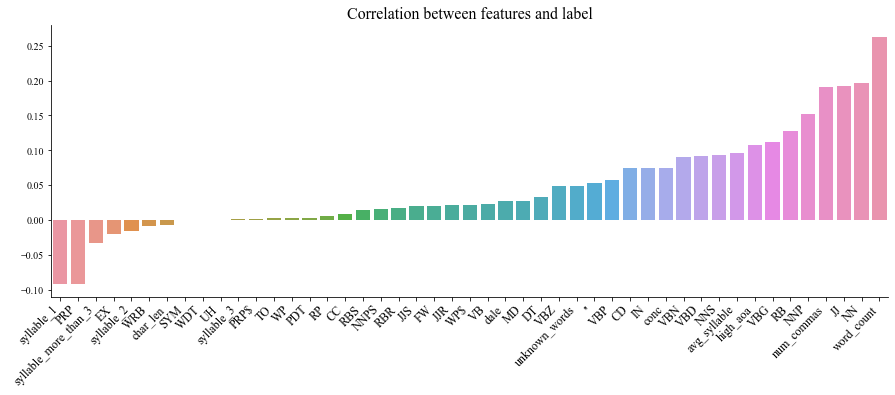

In [56]:
import seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
ax.set_title("Correlation between features and label", fontsize = 16)
ax.set_xticklabels(ax.get_xticks(), rotation = 45, fontsize = 12, ha = 'right')
sns.barplot(x = label.index, y = 'label', data = label)
plt.ylabel(" ")
sns.despine()


In [68]:
rfc_acc = pd.DataFrame(columns = ['n_estimators','Feature Only','Feature + Tfidf'],
                       data = [[100, 0.7207812462509298, 0.7112076205101135], 
                               [300,  0.7227847493821532, 0.7169990275293242],
                               [500,  0.72448832689493, 0.7183218561796675],
                               [700,  0.7238524845838232,  0.7181538978333374]])


In [74]:
rfc_melt = rfc_acc.melt('n_estimators')

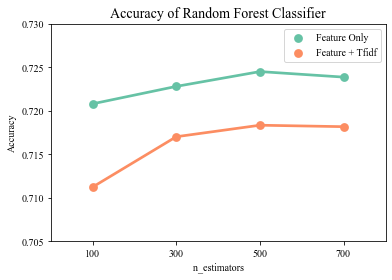

In [118]:
sns.pointplot(x='n_estimators', y = 'value', hue = 'variable', data = rfc_melt, palette = 'Set2')
plt.title("Accuracy of Random Forest Classifier", fontsize = 14)
plt.ylabel("Accuracy")
plt.ylim([0.705, 0.73])
plt.legend(title = "");
